<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/labmeeting/Oct18/InterpretSPI1ProfileModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/9e9880e93fef6c41b5ac40f33142b80305aae4f2/bqtls/profile_model/Spi1ProfileModel_rc.h5 -O Spi1ProfileModel_rc.h5

--2019-10-19 00:11:43--  https://raw.githubusercontent.com/AvantiShri/model_storage/9e9880e93fef6c41b5ac40f33142b80305aae4f2/bqtls/profile_model/Spi1ProfileModel_rc.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2078176 (2.0M) [application/octet-stream]
Saving to: ‘Spi1ProfileModel_rc.h5’

Spi1ProfileModel_rc 100%[===================>]   1.98M  --.-KB/s    in 0.04s   

2019-10-19 00:11:44 (46.6 MB/s) - ‘Spi1ProfileModel_rc.h5’ saved [2078176/2078176]



In [2]:
!pip install keras_genomics

Pulling in some regions around bQTLs on which to run the interpretation. This data is from Tehranchi et al., 2016 (we contacted the authors to get the full list, including non-significant bQTLs)

In [0]:
import gzip
import numpy as np

![[ -f SPI1.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/22db099/bqtls/SPI1.txt.gz -O SPI1.txt.gz

class BQTL(object):
  
  def __init__(self, chr, pos,
               depth, altdepth, refdepth,
               altallele, postallele,
               postfreq, prefreq, pvalue,
               #closest_summit_pos
               ):
    self.chr = chr
    self.start = pos-1
    self.end = pos
    self.depth=depth,
    self.altdepth=altdepth,
    self.refdepth=refdepth,
    self.altallele = altallele
    self.postallele = postallele
    self.postfreq = postfreq
    self.prefreq = prefreq
    self.logratio = np.log((self.postfreq+0.01)/(self.prefreq+0.01))
    self.pvalue = pvalue
    #self.closest_summit_pos = closest_summit_pos
    #self.closest_summit_dist = abs(int(self.closest_summit_pos-self.start))

bqtls = []
for (i,row) in enumerate(gzip.open("SPI1.txt.gz")):
    if (i > 0):
        row = row.decode("utf-8").rstrip()
        (chr, pos, depth, altdept, refdepth,
         altallele, postallele,
         postfreq, prefreq, pvalue) = row.split("\t")
        (pos, depth, altdepth, refdepth,
         postfreq, prefreq, pvalue) =\
         (int(pos), int(depth), int(altdept), int(refdepth),
          float(postfreq), float(prefreq), float(pvalue))
        bqtls.append(BQTL(chr=chr, pos=pos,
                          depth=depth, altdepth=altdepth, refdepth=refdepth,
                          altallele=altallele,
                          postallele=postallele,
                          postfreq=postfreq, prefreq=prefreq, pvalue=pvalue))
        
significant_bqtls = sorted([x for x in bqtls if x.pvalue <= 5e-5],
                           key=lambda x: -np.abs(x.logratio))

The bQTL coordinates are in the hg19 genome format, so need to pull those coordinates in

In [0]:
#The SNPs are all in hg19, so need to download the hg19 genome
#Get hg19 fasta by download 2bit and then converting to fa
![[ -f hg19.2bit ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.2bit -O hg19.2bit  
![[ -f twoBitToFa ]] || wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/twoBitToFa -O twoBitToFa
!chmod a+x twoBitToFa
![[ -f hg19.genome.fa ]] || ./twoBitToFa hg19.2bit hg19.genome.fa

In [5]:
!pip install pyfaidx

Annotate each SNP with the flanking sequence info needed to run the profile model

In [0]:
def annotate_snps_with_flankinfo(snp_list):
    import pyfaidx
    from pyfaidx import Fasta
    #first time this is executed, will build the index if it's
    # not there
    fasta = Fasta("hg19.genome.fa")
    for (i,snp) in enumerate(snp_list):
        left_flank = fasta[snp.chr][snp.end-673:snp.end].seq
        right_flank = fasta[snp.chr][snp.end:snp.end+673].seq
        snp.left_flank = left_flank
        snp.right_flank = right_flank

annotate_snps_with_flankinfo(significant_bqtls)

Clone and install deepshap

In [7]:
!git clone https://github.com/AvantiShri/shap.git
%cd /content/shap
!pip uninstall shap
!git pull
!pip install .
%cd /content

from importlib import reload
import shap
reload(shap.explainers.deep)
reload(shap.explainers)
reload(shap)

fatal: destination path 'shap' already exists and is not an empty directory.
/content/shap
Uninstalling shap-0.29.3:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/shap-0.29.3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/shap/*
Proceed (y/n)? y
  Successfully uninstalled shap-0.29.3
Already up to date.
Processing /content/shap
  Created wheel for shap: filename=shap-0.29.3-cp36-cp36m-linux_x86_64.whl size=347398 sha256=6ac8b049455dc9caefb49a5d30358d7e5fbc39ba60228b4d1355d57252e2e3fc
  Stored in directory: /tmp/pip-ephem-wheel-cache-93ut9d_f/wheels/08/fe/b1/461bb216b26aa22db99708d72d320d2f3637775309af9f79b5
Successfully built shap
/content


<module 'shap' from '/usr/local/lib/python3.6/dist-packages/shap/__init__.py'>

Load the keras profile model

In [8]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import tensorflow as tf
import tensorflow_probability as tfp

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))


#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

#to reload, you need to set up a CustomObjectScope
from keras.utils import CustomObjectScope
from keras.models import load_model
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,
                        'RevCompConv1D': RevCompConv1D}):
  model = load_model('Spi1ProfileModel_rc.h5')

model.summary()

Using TensorFlow backend.











Instructions for updating:
Use `tf.cast` instead.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           (None, 1346, 4)      0                                            
__________________________________________________________________________________________________
rev_comp_conv1d_1 (RevCompConv1 (None, 1326, 128)    5440        sequence[0][0]                   
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1322, 128)    0           rev_comp_conv1d_1[0][0]          
__________________________________________________________________________________________________
rev_comp_conv1d_2 (RevCompConv1 (None, 1322, 128)    24640       rev_comp_conv1d_1[0][0]          
_______________________________

Install deeplift for visualization and dinucleotide shuffling functionality

In [9]:
!pip install deeplift

In [10]:
import shap
from deeplift.dinuc_shuffle import dinuc_shuffle

def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    for l in [0]:
        projected_hypothetical_contribs = np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        #At each position in the input sequence, we iterate over the one-hot encoding
        # possibilities (eg: for genomic sequence, this is ACGT i.e.
        # 1000, 0100, 0010 and 0001) and compute the hypothetical 
        # difference-from-reference in each case. We then multiply the hypothetical
        # differences-from-reference with the multipliers to get the hypothetical contributions.
        #For each of the one-hot encoding possibilities,
        # the hypothetical contributions are then summed across the ACGT axis to estimate
        # the total hypothetical contribution of each position. This per-position hypothetical
        # contribution is then assigned ("projected") onto whichever base was present in the
        # hypothetical sequence.
        #The reason this is a fast estimate of what the importance scores *would* look
        # like if different bases were present in the underlying sequence is that
        # the multipliers are computed once using the original sequence, and are not
        # computed again for each hypothetical sequence.
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:,i] = 1.0
            hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference*mult[l]
            projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1) 
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))
    to_return.append(np.zeros_like(orig_inp[1]))
    return to_return

def shuffle_several_times(s):
    numshuffles=20
    return [np.array([dinuc_shuffle(s[0]) for i in range(numshuffles)]),
            np.array([s[1] for i in range(numshuffles)])]

profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
    ([model.input[0], model.input[1]],
     tf.reduce_sum(model.outputs[0],axis=-1)),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)

#See Google slide deck for explanations
#We meannorm as per section titled "Adjustments for Softmax Layers"
# in the DeepLIFT paper
meannormed_logits = (
    model.outputs[1]-
    tf.reduce_mean(model.outputs[1],axis=1)[:,None,:])
#'stop_gradient' will prevent importance from being propagated through
# this operation; we do this because we just want to treat the post-softmax
# probabilities as 'weights' on the different logits, without having the
# network explain how the probabilities themselves were derived
#Could be worth contrasting explanations derived with and without stop_gradient
# enabled...
stopgrad_meannormed_logits = tf.stop_gradient(meannormed_logits)
softmax_out = tf.nn.softmax(stopgrad_meannormed_logits,axis=1)
#Weight the logits according to the softmax probabilities, take the sum for each
# example. This mirrors what was done for the bpnet paper.
weightedsum_meannormed_logits = tf.reduce_sum(softmax_out*meannormed_logits,
                                              axis=(1,2))
profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
    ([model.input[0], model.input[2]],
     weightedsum_meannormed_logits),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)


Run DeepSHAP to annotate a few SNPs

In [11]:
onehot_mapping = {
    'A': [1,0,0,0],
    'C': [0,1,0,0],
    'G': [0,0,1,0],
    'T': [0,0,0,1],
    'a': [1,0,0,0],
    'c': [0,1,0,0],
    'g': [0,0,1,0],
    't': [0,0,0,1],
}

def one_hot_encode(sequence):
  return np.array([onehot_mapping[x] for x in sequence])

def annotate_snps_with_post_and_alt_profile_preds(
    snp_list, profile_model,
    profile_model_counts_explainer,
    profile_model_profile_explainer):
  
    post_onehot = np.array([one_hot_encode(x.left_flank[-672:]
                                            +x.postallele
                                            +x.right_flank[:673])
                            for x in snp_list])
    alt_onehot = np.array([one_hot_encode(x.left_flank[-672:]
                                          +x.altallele
                                          +x.right_flank[:673])
                           for x in snp_list])
    #get predictions when providing zeros for the bias tracks
    post_counts_preds, post_profile_preds = profile_model.predict([
                                                post_onehot,
                                                np.zeros((len(post_onehot), 1)),
                                                np.zeros((len(post_onehot), 1000, 2))])
    alt_counts_preds, alt_profile_preds = profile_model.predict([
                                                alt_onehot,
                                                np.zeros((len(post_onehot), 1)),
                                                np.zeros((len(post_onehot), 1000, 2))])
    
    for (post_counts_pred, alt_counts_pred,
         post_profile_pred, alt_profile_pred, snp) in zip(
            post_counts_preds, alt_counts_preds,
            post_profile_preds, alt_profile_preds, snp_list):
        snp.post_counts_pred = post_counts_pred
        snp.alt_counts_pred = alt_counts_pred
        snp.post_profile_pred = post_profile_pred
        snp.alt_profile_pred = alt_profile_pred
    
    #The shap scores too
    post_counts_hypimps,_ = profile_model_counts_explainer.shap_values(
        [post_onehot, np.zeros((len(post_onehot), 1))],
        progress_message=10)
    alt_counts_hypimps,_ = profile_model_counts_explainer.shap_values(
        [alt_onehot, np.zeros((len(alt_onehot), 1))],
        progress_message=10)
    post_profile_hypimps,_ = profile_model_profile_explainer.shap_values(
        [post_onehot, np.zeros((len(post_onehot), 1000, 2))],
        progress_message=10)
    alt_profile_hypimps,_ = profile_model_profile_explainer.shap_values(
        [alt_onehot, np.zeros((len(alt_onehot), 1000, 2))],
        progress_message=10)
    
    post_counts_actualimps = post_counts_hypimps*post_onehot
    post_profile_actualimps = post_profile_hypimps*post_onehot
    
    alt_counts_actualimps = alt_counts_hypimps*alt_onehot
    alt_profile_actualimps = alt_profile_hypimps*alt_onehot  
    
    for i in range(len(snp_list)):
        snp_list[i].post_counts_hypimp = post_counts_hypimps[i]
        snp_list[i].alt_counts_hypimp = alt_counts_hypimps[i]
        snp_list[i].post_profile_hypimp = post_profile_hypimps[i]
        snp_list[i].alt_profile_hypimp = alt_profile_hypimps[i]
        snp_list[i].post_counts_actualimp = post_counts_actualimps[i]
        snp_list[i].alt_counts_actualimp = alt_counts_actualimps[i]
        snp_list[i].post_profile_actualimp = post_profile_actualimps[i]
        snp_list[i].alt_profile_actualimp = alt_profile_actualimps[i]    

annotate_snps_with_post_and_alt_profile_preds(
    significant_bqtls[:10],
    profile_model=model,
    profile_model_counts_explainer=profile_model_counts_explainer,
    profile_model_profile_explainer=profile_model_profile_explainer)

Done 0 examples of 10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Done 0 examples of 10
Done 0 examples of 10
Done 0 examples of 10


idx, snp pos 52536308 52536309 logratio -4.149698596613066 pvalue 4.47043413028584e-10
Post allele, counts pred [2.2654583 2.3232236]
Post allele profile pred


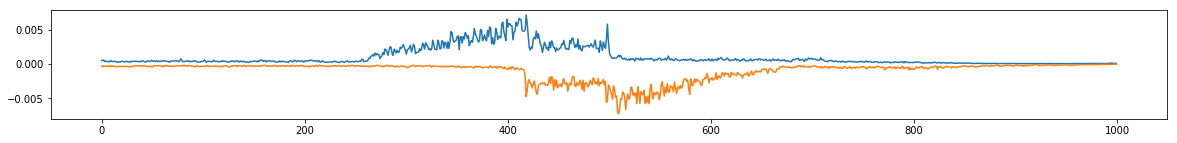

Post allele counts imp


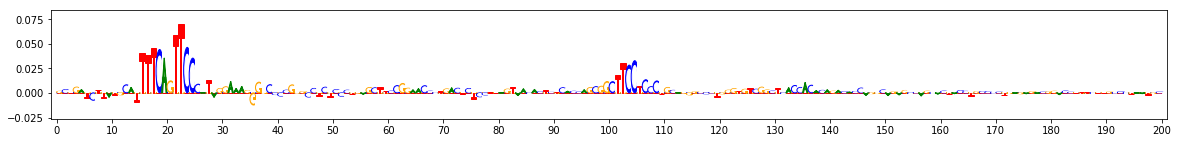

Post allele profile imp


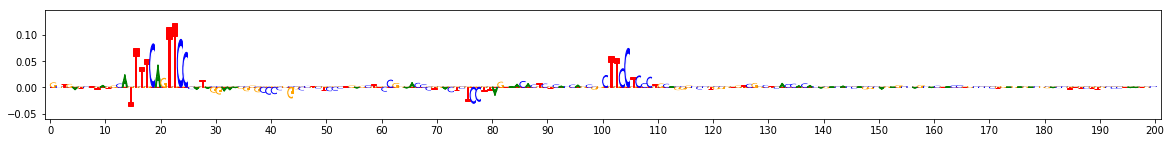

Alt allele:
Alt allele, counts pred [2.52279   2.5882037]


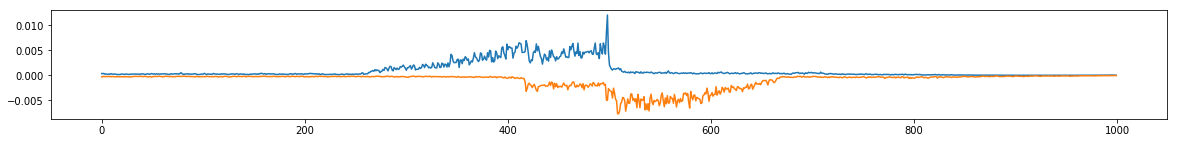

Alt allele counts imp


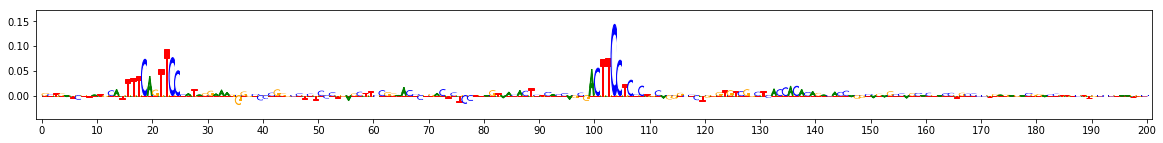

Alt allele profile imp


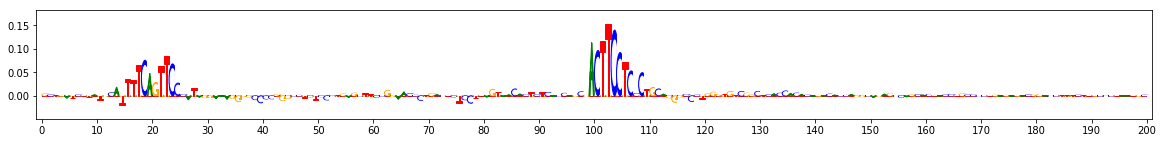

idx, snp pos 21754995 21754996 logratio -4.089977797474426 pvalue 1.20170491449766e-07
Post allele, counts pred [2.1622765 2.1416998]
Post allele profile pred


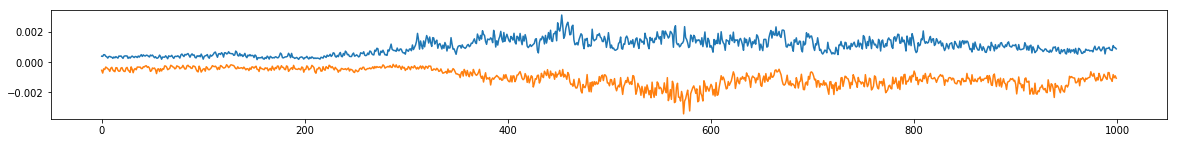

Post allele counts imp


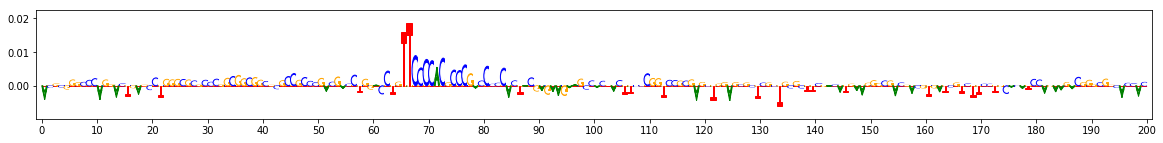

Post allele profile imp


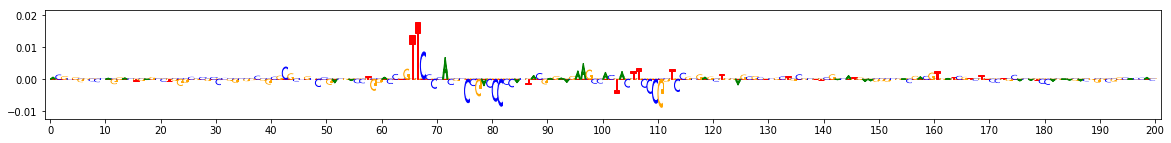

Alt allele:
Alt allele, counts pred [2.1726944 2.1518114]


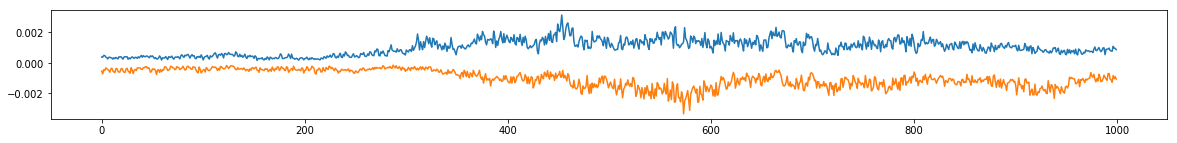

Alt allele counts imp


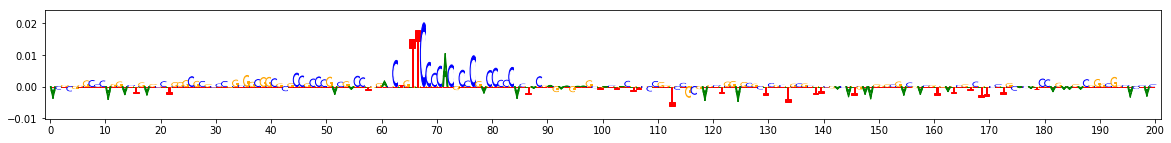

Alt allele profile imp


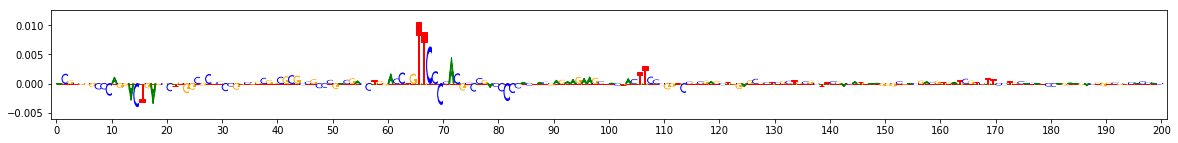

idx, snp pos 216195280 216195281 logratio -4.079079591214075 pvalue 6.66541914880443e-08
Post allele, counts pred [1.9641609 2.00946  ]
Post allele profile pred


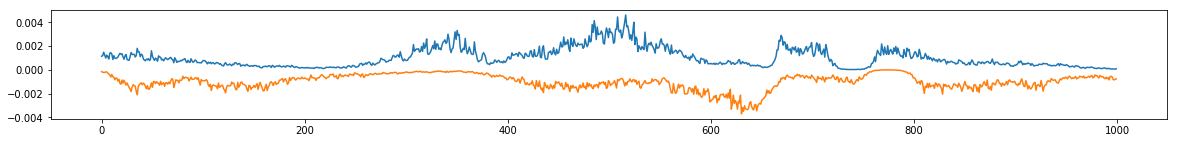

Post allele counts imp


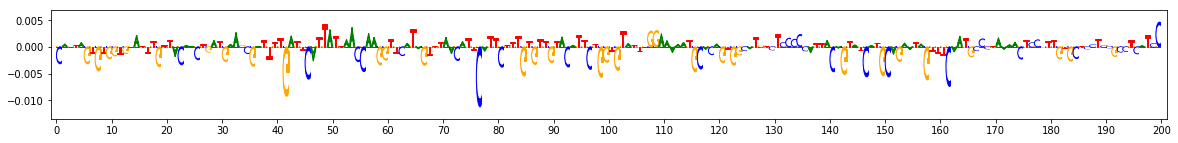

Post allele profile imp


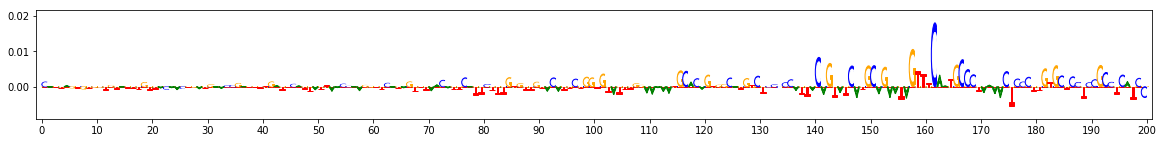

Alt allele:
Alt allele, counts pred [1.9648323 2.0093467]


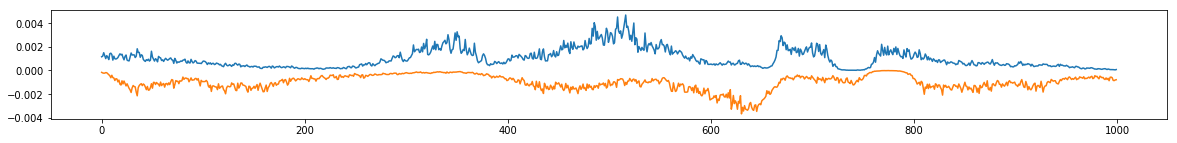

Alt allele counts imp


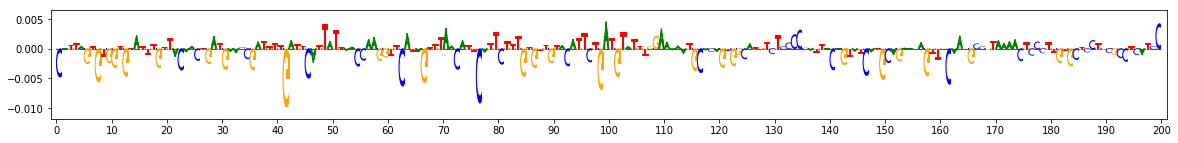

Alt allele profile imp


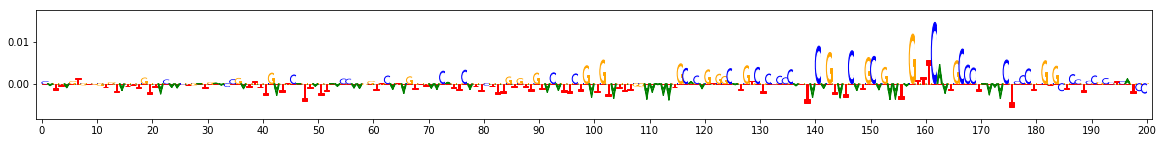

idx, snp pos 94265356 94265357 logratio -4.02117675634378 pvalue 1.38928741655431e-06
Post allele, counts pred [2.0740662 2.0744927]
Post allele profile pred


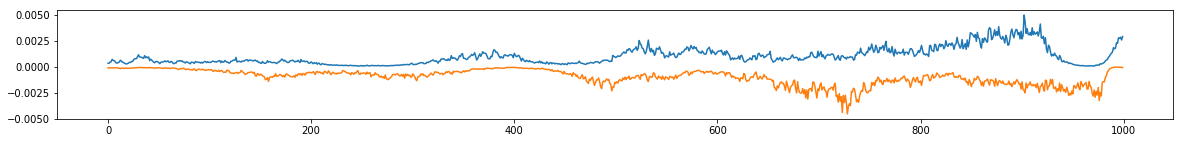

Post allele counts imp


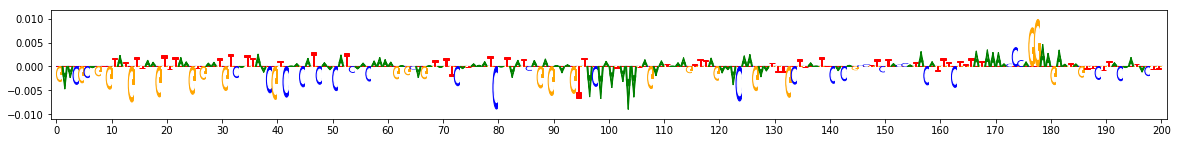

Post allele profile imp


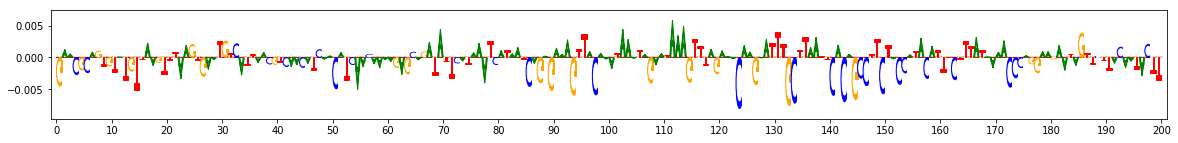

Alt allele:
Alt allele, counts pred [2.0709684 2.0719557]


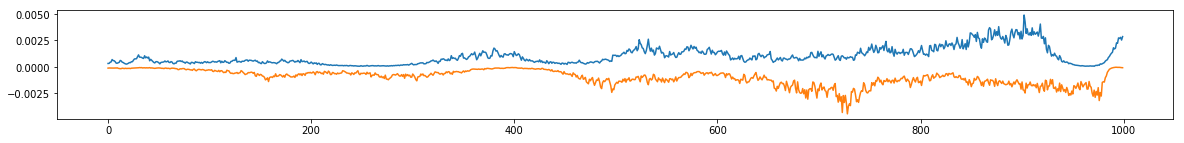

Alt allele counts imp


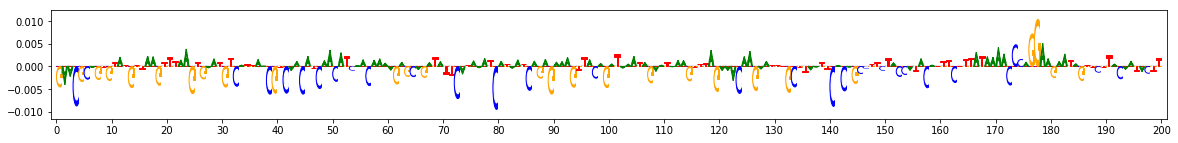

Alt allele profile imp


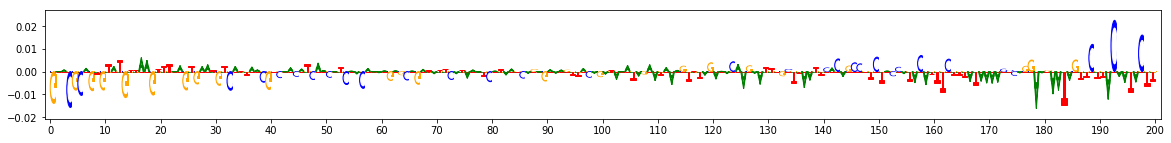

idx, snp pos 60240729 60240730 logratio -3.9636372221769993 pvalue 1.00877383094879e-06
Post allele, counts pred [2.2618184 2.1216338]
Post allele profile pred


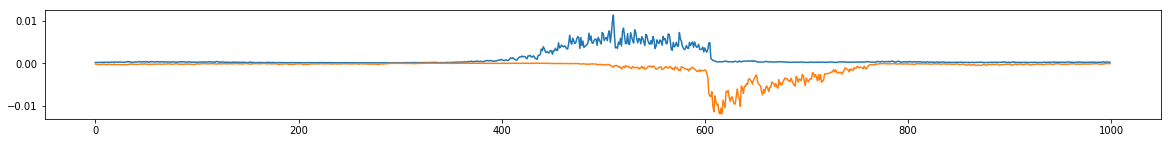

Post allele counts imp


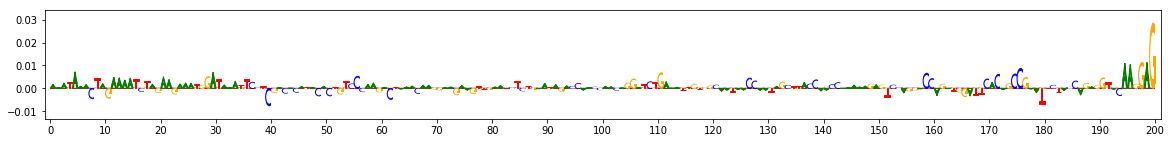

Post allele profile imp


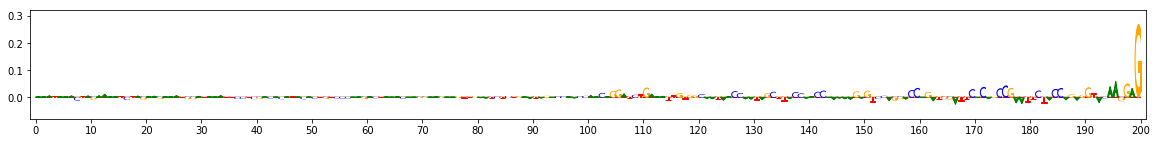

Alt allele:
Alt allele, counts pred [2.3856068 2.2361908]


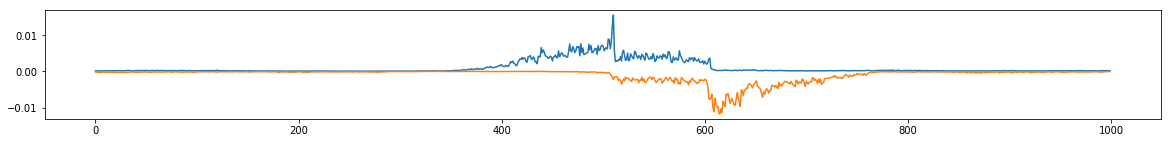

Alt allele counts imp


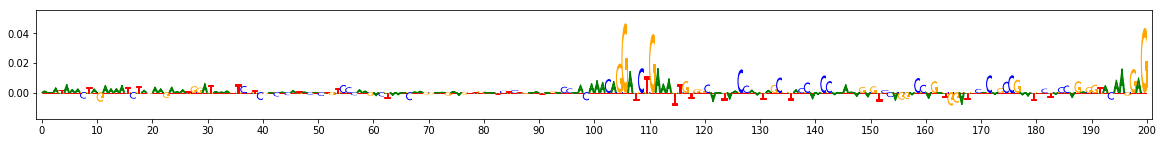

Alt allele profile imp


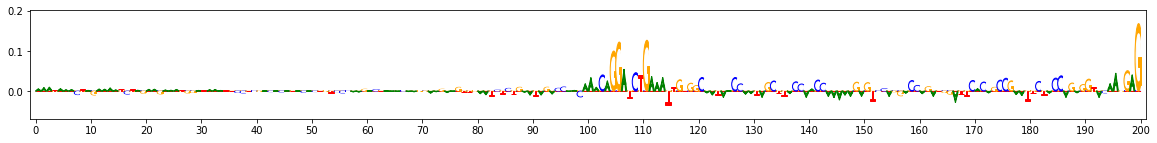

idx, snp pos 104812860 104812861 logratio -3.962963425739213 pvalue 9.02937570040754e-06
Post allele, counts pred [1.9188883 2.0359943]
Post allele profile pred


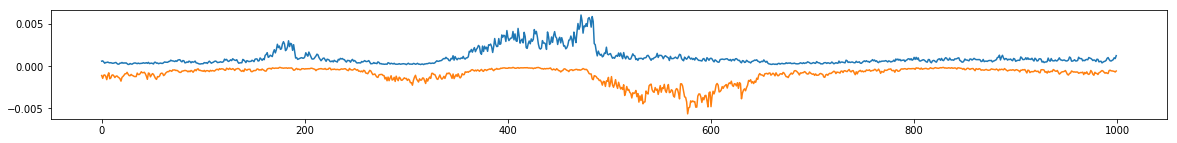

Post allele counts imp


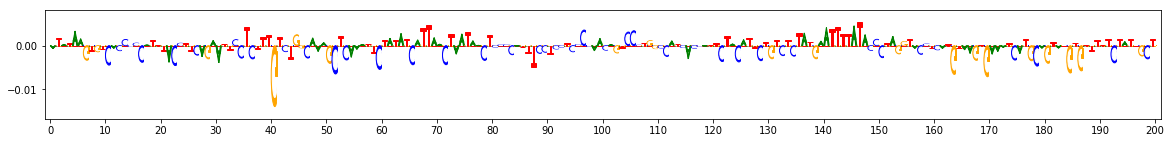

Post allele profile imp


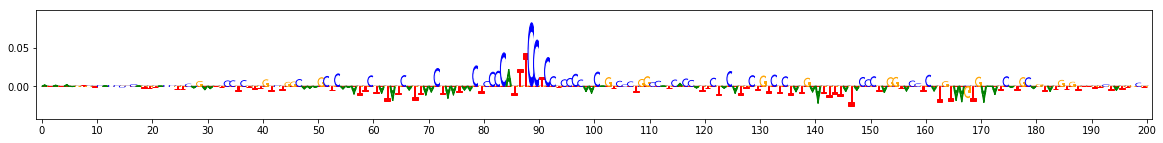

Alt allele:
Alt allele, counts pred [1.9143091 2.0313237]


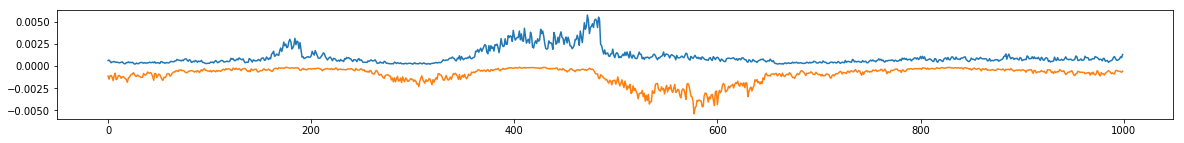

Alt allele counts imp


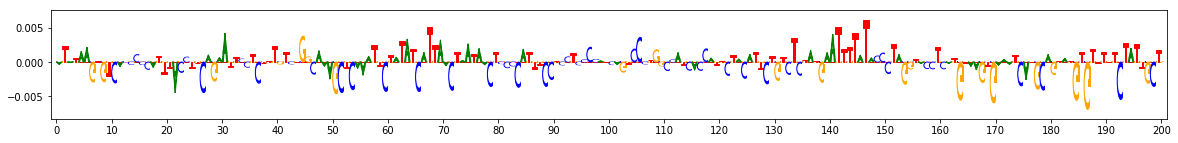

Alt allele profile imp


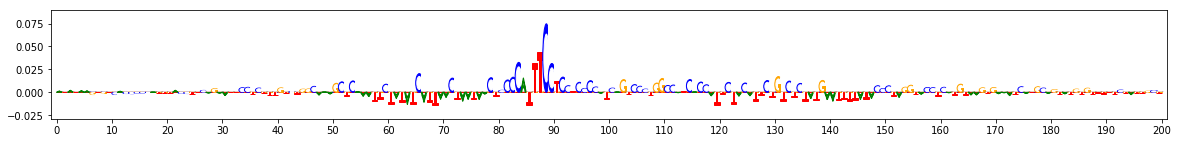

idx, snp pos 19015380 19015381 logratio -3.953214929244744 pvalue 1.04024977748099e-126
Post allele, counts pred [2.2610316 2.2323904]
Post allele profile pred


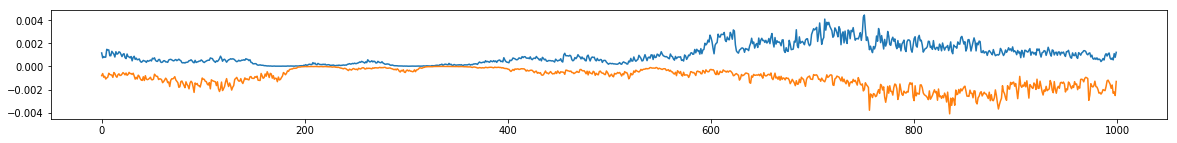

Post allele counts imp


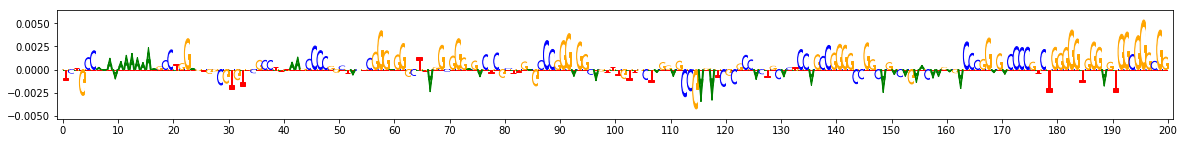

Post allele profile imp


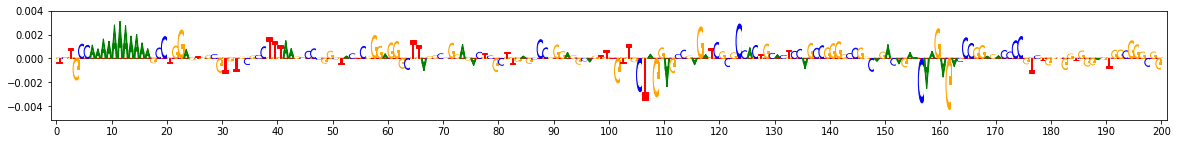

Alt allele:
Alt allele, counts pred [2.2611458 2.2301636]


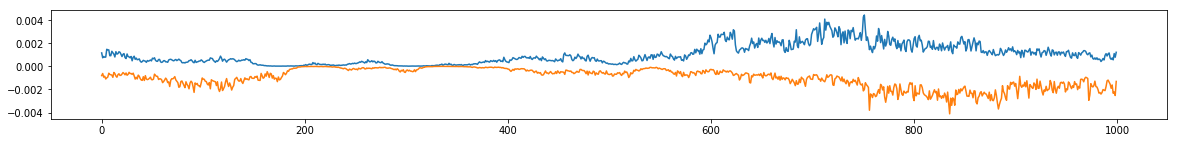

Alt allele counts imp


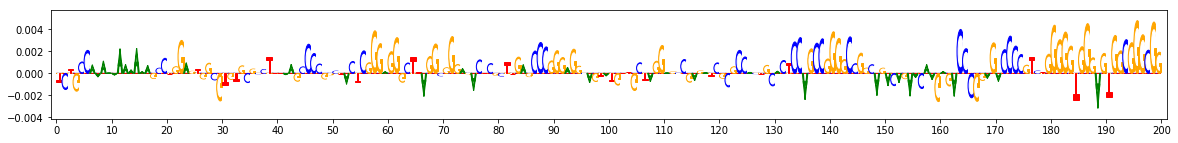

Alt allele profile imp


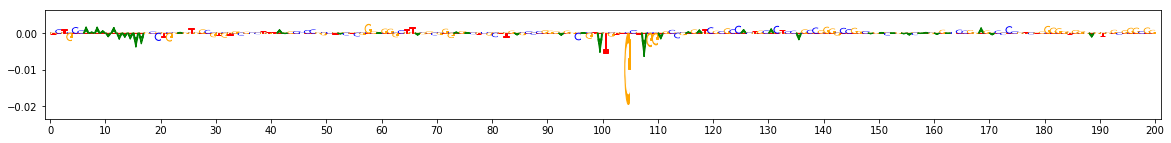

idx, snp pos 203372484 203372485 logratio -3.9460621085600334 pvalue 1.20543627955117e-05
Post allele, counts pred [1.9194233 1.9785286]
Post allele profile pred


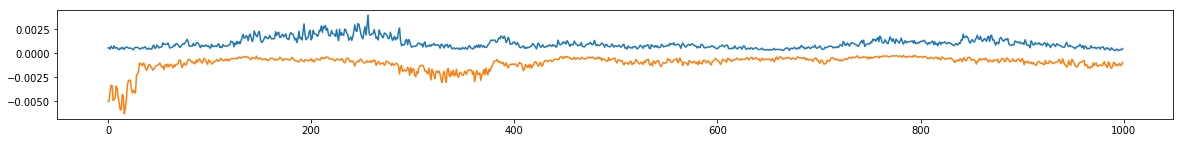

Post allele counts imp


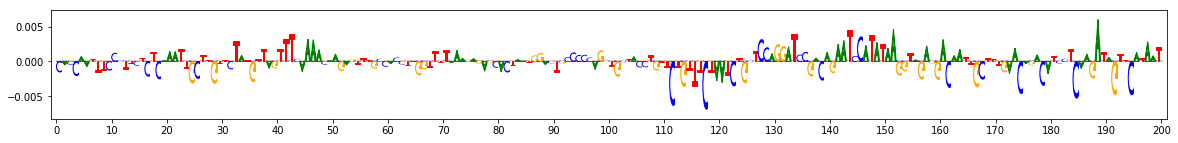

Post allele profile imp


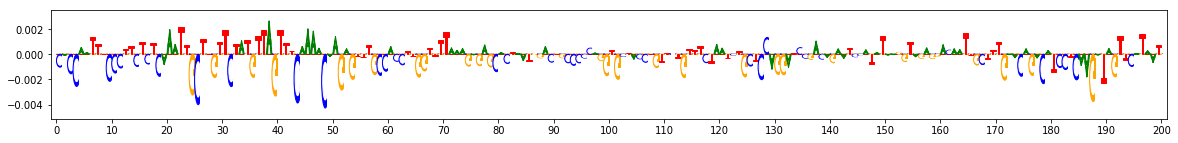

Alt allele:
Alt allele, counts pred [1.9182869 1.9775878]


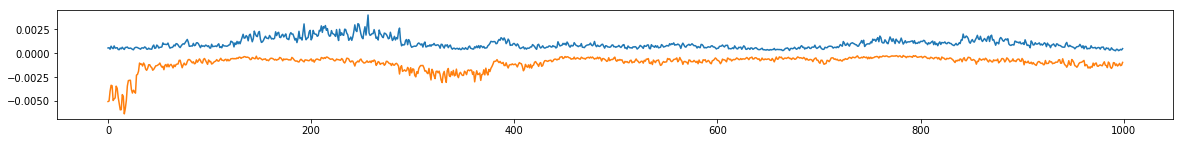

Alt allele counts imp


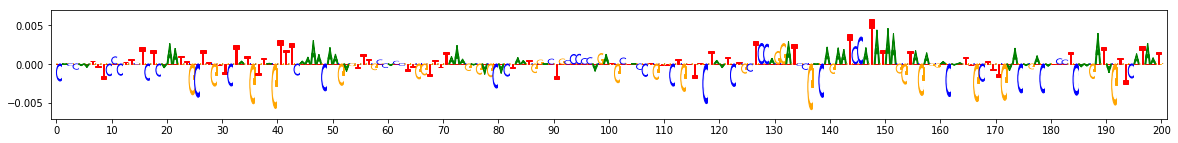

Alt allele profile imp


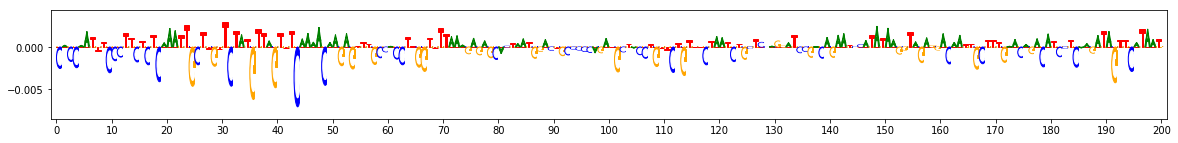

idx, snp pos 67589568 67589569 logratio -3.942978791687778 pvalue 6.27396945389492e-06
Post allele, counts pred [1.9706953 2.0273232]
Post allele profile pred


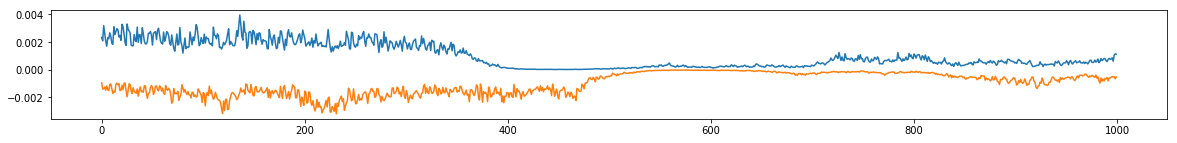

Post allele counts imp


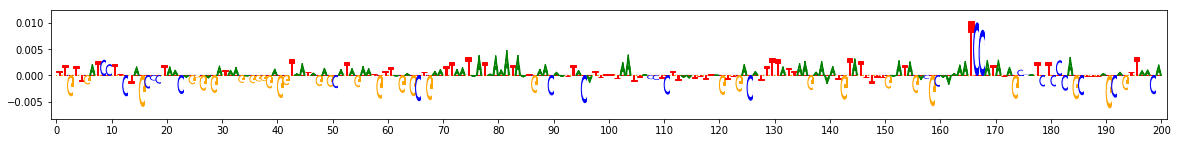

Post allele profile imp


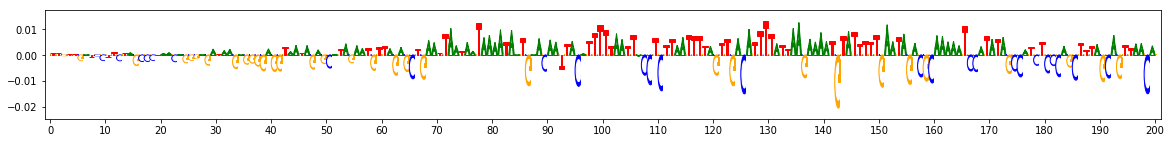

Alt allele:
Alt allele, counts pred [1.9712597 2.0276492]


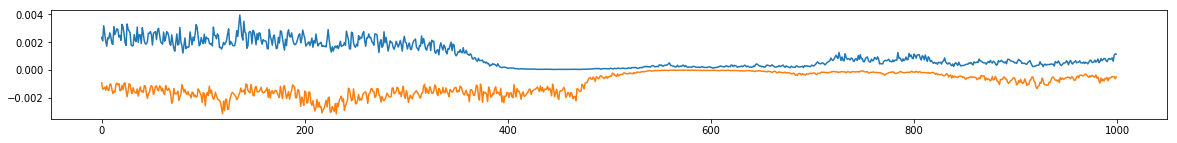

Alt allele counts imp


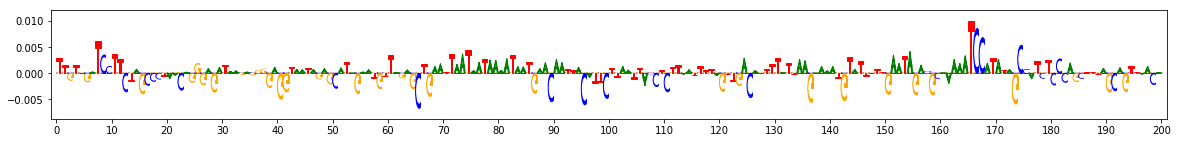

Alt allele profile imp


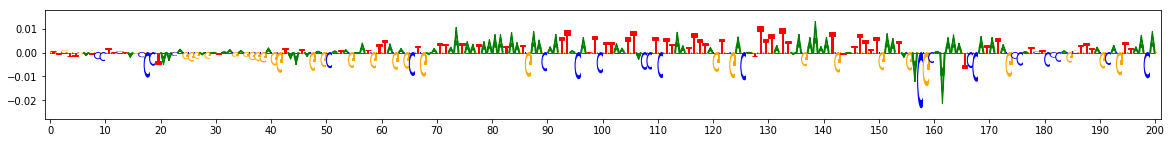

idx, snp pos 66133778 66133779 logratio -3.9292741279452645 pvalue 3.8191049241283e-06
Post allele, counts pred [2.002791  1.9759394]
Post allele profile pred


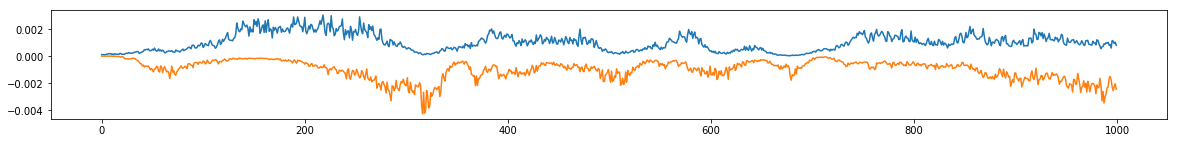

Post allele counts imp


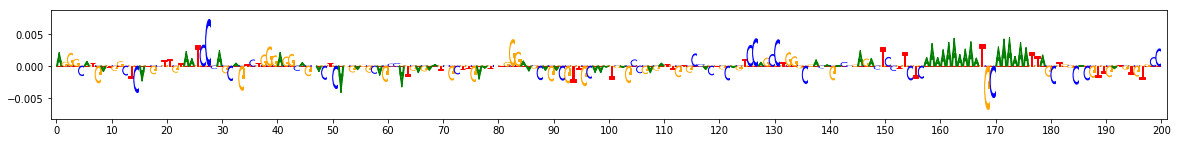

Post allele profile imp


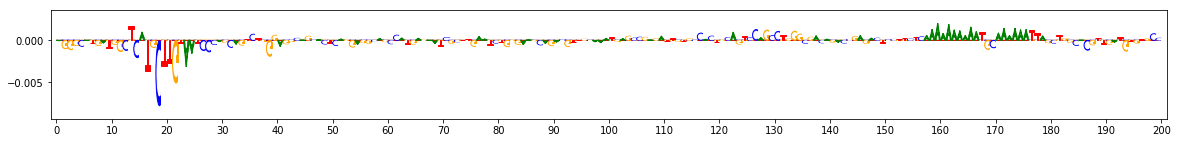

Alt allele:
Alt allele, counts pred [2.0031042 1.9771767]


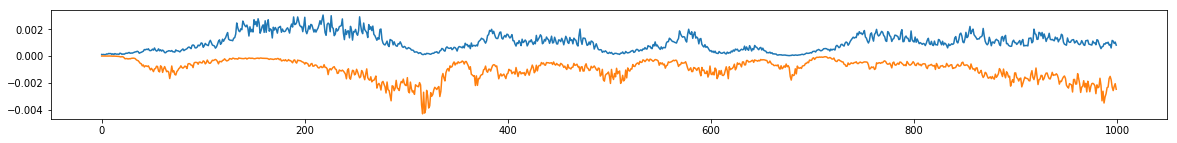

Alt allele counts imp


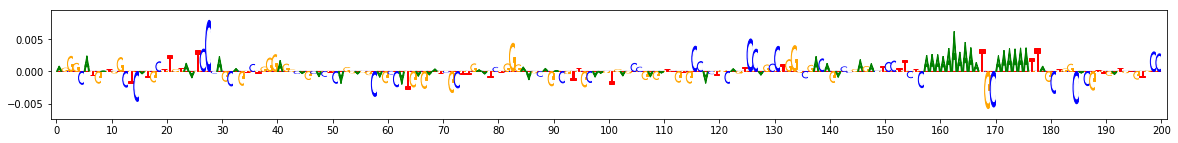

Alt allele profile imp


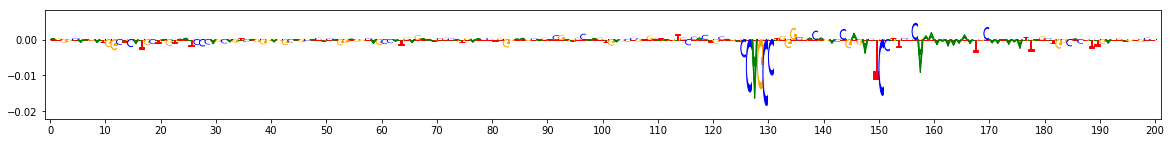

In [12]:
from deeplift.visualization import viz_sequence
from matplotlib import pyplot as plt
from scipy.special import softmax

for i in range(10):
  bqtl = significant_bqtls[i]
  print("idx, snp pos",bqtl.start, bqtl.end,
        "logratio", bqtl.logratio, "pvalue", bqtl.pvalue)
  print("Post allele, counts pred",bqtl.post_counts_pred)
  print("Post allele profile pred")
  post_profile_pred = softmax(bqtl.post_profile_pred, axis=0)
  fig = plt.figure(figsize=(20,2))
  plt.plot(post_profile_pred[:,0])
  plt.plot(post_profile_pred[:,1]*-1)
  plt.show()
  print("Post allele counts imp")
  viz_sequence.plot_weights(bqtl.post_counts_actualimp[573:773],
                            subticks_frequency=10)
  print("Post allele profile imp")
  viz_sequence.plot_weights(bqtl.post_profile_actualimp[573:773],
                            subticks_frequency=10)
  
  print("Alt allele:")
  print("Alt allele, counts pred",bqtl.alt_counts_pred)  
  alt_profile_pred = softmax(bqtl.alt_profile_pred, axis=0)
  fig = plt.figure(figsize=(20,2))
  plt.plot(alt_profile_pred[:,0])
  plt.plot(alt_profile_pred[:,1]*-1)
  plt.show()
  print("Alt allele counts imp")
  viz_sequence.plot_weights(bqtl.alt_counts_actualimp[573:773],
                            subticks_frequency=10)
  print("Alt allele profile imp")
  viz_sequence.plot_weights(bqtl.alt_profile_actualimp[573:773],
                            subticks_frequency=10)
